# Session 4 — Paragraph-Level Analysis
## Measure 5: Paragraph Function Classification

In this notebook, you will:
- define a small set of **paragraph function labels**
  (dialogue, action, description, internal_monologue, other)
- create short **prototype texts** for each label
- embed both prototypes and real paragraphs with MiniLM
- assign to each paragraph the label whose prototype is most similar.

This mimics how agentic LLM systems classify chunks of text into roles
(instruction, context, plan, reflection, etc.).


In [1]:
import re
from typing import List, Dict
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import gc

# Initialize Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- 1. Load Data ---
def load_book(filepath: str) -> str:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return ""
    if 'CHAPTER I' in text:
        text = text[text.find('CHAPTER I'):]
    return text.strip()

# Corrected paths
fellowship_text = load_book('../data/Fellowship.txt')
towers_text = load_book('../data/TwoTowers.txt')
king_text = load_book('../data/TheKing.txt')

c:\Users\vlads\OneDrive\Desktop\nlp\applied-NLP-week1-drafts1\applied-NLP-week4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def split_into_paragraphs(text: str, min_words: int = 5) -> List[str]:
    """
    UNIVERSAL SPLITTER (Patched for 'The King')
    Forces a split on EVERY newline to handle varying file formats.
    """
    # 1. Normalize all newlines to standard \n
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    
    # 2. Split on EVERY single newline (Aggressive Mode)
    # This works for The King (single lines) AND Fellowship (double lines)
    # because empty strings from double lines get filtered out below.
    paras = text.split('\n')
    
    # 3. Clean and Filter
    # We lowered min_words to 5 to catch short dialogue like "Yes." or "No."
    cleaned_paras = []
    for p in paras:
        p = p.strip()
        # Skip empty lines or tiny artifacts
        if len(p.split()) >= min_words:
            cleaned_paras.append(p)
            
    return cleaned_paras
def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1: a = a.reshape(-1)
    if b.ndim > 1: b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float(np.dot(a, b) / denom) if denom != 0 else 0.0

# Prototypes define the "center" of each category
PROTOTYPES: Dict[str, List[str]] = {
    'dialogue': [
        '"What are you doing?" he asked.',
        '"I do not know," said Frodo.',
        '"Go back!" she cried out loud.',
        'He spoke clearly: "We must leave at dawn."'
    ],
    'action': [
        'He drew his sword and ran forward.',
        'The orcs charged across the field.',
        'They climbed the steep stairs, panting for breath.',
        'She jumped over the log and sprinted into the trees.'
    ],
    'description': [
        'The mountain stood tall and grey against the sky.',
        'The room was dark, filled with the smell of old books.',
        'It was a cold morning, and the mist covered the valley.',
        'The path wound through the forest, covered in fallen leaves.'
    ],
    'internal_monologue': [
        # STRICTER: Use first-person "I" and explicit thought markers
        'I wonder if I will ever see home again, he thought.',
        'In his mind, he debated whether to turn back or keep going.',
        '"Why is he looking at me like that?" she wondered.',
        'He thought to himself: this is a bad idea.'
    ],
    'other': [
        'Chapter 1: A Long-Expected Party',
        'The history of the Ring goes back many years.',
        '*** END OF BOOK ***'
    ],
}

# You must re-run the `build_prototype_embeddings` and `classify_all` functions
# after changing this list for it to take effect!


def build_prototype_embeddings() -> Dict[str, np.ndarray]:
    proto_embs = {}
    for label, examples in PROTOTYPES.items():
        embs = model.encode(examples)
        proto_embs[label] = embs.mean(axis=0)
    return proto_embs

prototype_embeddings = build_prototype_embeddings()

def classify_paragraph_embedding(paragraph: str, proto_embs: Dict[str, np.ndarray]) -> str:
    emb = model.encode(paragraph)
    best_label = None
    best_sim = -1.0
    for label, proto in proto_embs.items():
        sim = cosine_similarity(emb, proto)
        if sim > best_sim:
            best_sim = sim
            best_label = label
    return best_label or 'other'

def classify_all(paragraphs: List[str], proto_embs: Dict[str, np.ndarray]) -> List[str]:
    labels = []
    for p in paragraphs:
        if len(p.split()) < 5: continue
        labels.append(classify_paragraph_embedding(p, proto_embs))
    return labels

In [19]:
print("Classifying Fellowship...")
f_labels = classify_all(split_into_paragraphs(fellowship_text), prototype_embeddings)

print("Classifying Two Towers...")
t_labels = classify_all(split_into_paragraphs(towers_text), prototype_embeddings)

print("Classifying The King...")
k_labels = classify_all(split_into_paragraphs(king_text), prototype_embeddings)

def label_counts(labels: List[str], title: str) -> Counter:
    c = Counter(labels)
    total = sum(c.values()) or 1
    print(f"\n{title}:")
    for k, v in c.items():
        print(f"{k:18s}: {v:4d} ({v/total*100:5.1f}%)")
    return c

f_counts = label_counts(f_labels, "Fellowship")
t_counts = label_counts(t_labels, "Two Towers")
k_counts = label_counts(k_labels, "The King")

Classifying Fellowship...
Classifying Two Towers...
Classifying The King...

Fellowship:
other             :  643 ( 17.3%)
description       : 1014 ( 27.2%)
action            :  510 ( 13.7%)
internal_monologue:  159 (  4.3%)
dialogue          : 1397 ( 37.5%)

Two Towers:
action            :  583 ( 20.7%)
dialogue          : 1207 ( 42.8%)
description       :  643 ( 22.8%)
other             :  250 (  8.9%)
internal_monologue:  140 (  5.0%)

The King:
other             :  339 ( 14.5%)
description       :  574 ( 24.5%)
dialogue          :  890 ( 38.0%)
action            :  430 ( 18.4%)
internal_monologue:  107 (  4.6%)


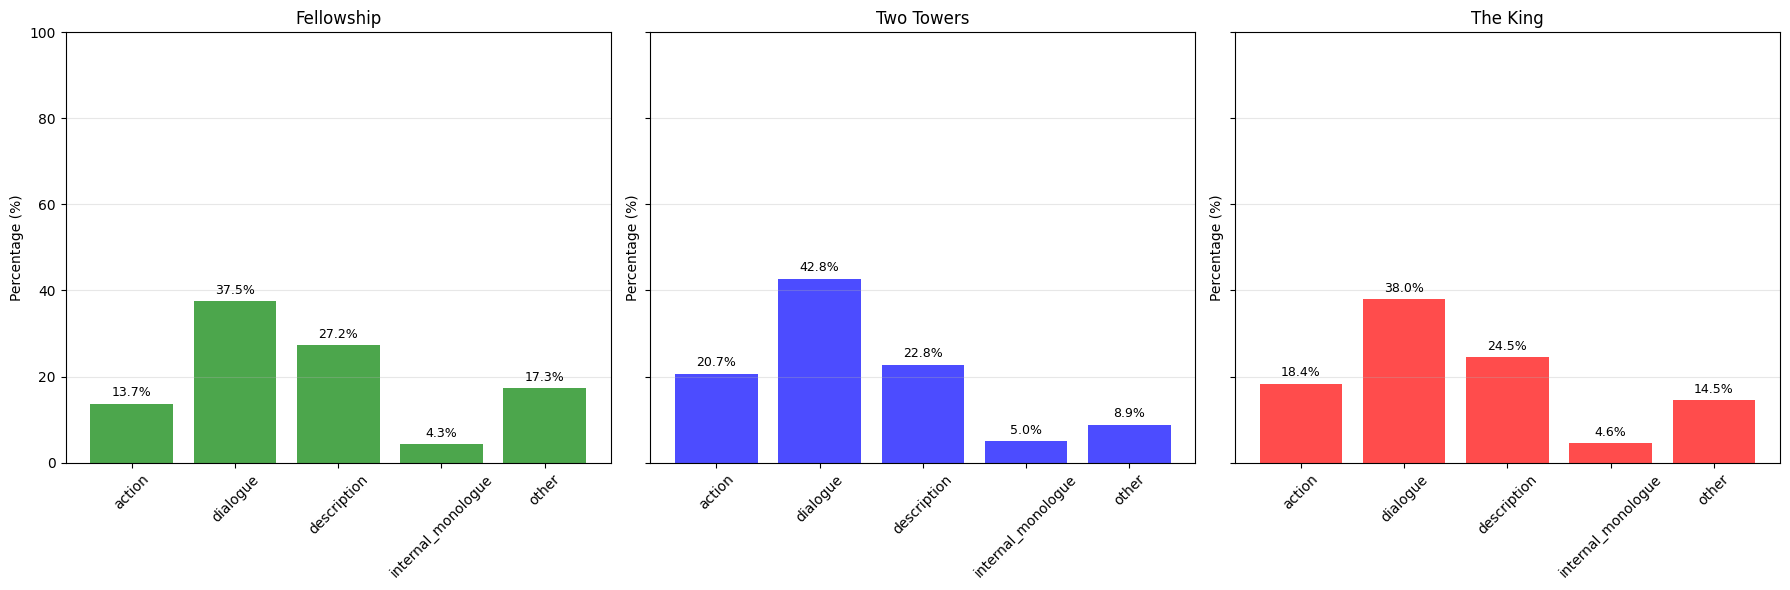

In [20]:
# Define the standard order for all graphs
ALL_LABELS = ['action', 'dialogue', 'description', 'internal_monologue', 'other']

def plot_fixed_percentage_bars(counts: Counter, title: str, ax, color):
    total = sum(counts.values())
    
    # If the book is empty/not loaded, handle it gracefully
    if total == 0:
        values = [0] * len(ALL_LABELS)
    else:
        # Get count for each label in ALL_LABELS, defaulting to 0 if missing
        values = [(counts.get(l, 0) / total) * 100 for l in ALL_LABELS]
    
    # Plot
    bars = ax.bar(ALL_LABELS, values, color=color, alpha=0.7)
    
    ax.set_title(title)
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 100)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add text labels (only if > 0 to avoid clutter)
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%',
                    ha='center', va='bottom', fontsize=9)

# Plot again with fixed axes
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

plot_fixed_percentage_bars(f_counts, 'Fellowship', axes[0], 'green')
plot_fixed_percentage_bars(t_counts, 'Two Towers', axes[1], 'blue')
plot_fixed_percentage_bars(k_counts, 'The King', axes[2], 'red')

plt.tight_layout()
plt.show()

## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.

In [ ]:
del fellowship_text, towers_text, king_text
del f_labels, t_labels, k_labels
del f_counts, t_counts, k_counts
del model
gc.collect()

Reloading The King...
⚡ Nuclear Split finished. Found 2340 paragraphs.
✅ Success! Data looks realistic (2340 chunks).
Re-classifying (this will take longer now)...

The King (Aggressive Split):
other             :  339 ( 14.5%)
description       :  574 ( 24.5%)
dialogue          :  890 ( 38.0%)
action            :  430 ( 18.4%)
internal_monologue:  107 (  4.6%)


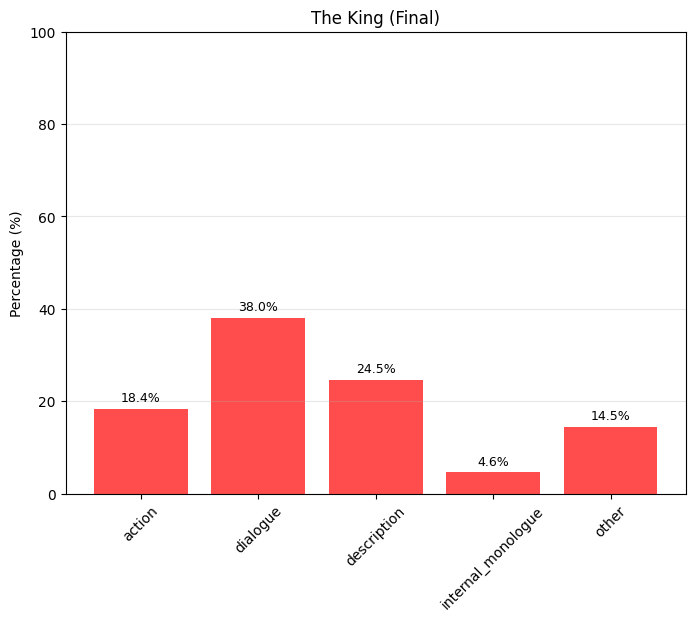


Found 890 dialogue snippets. First 3:
 - ‘Where are we, Gandalf?’ he asked.
 - ‘Sleep again, and do not be afraid!’ said Gandalf. ‘For you are not going like Frodo to Mordor, but to Minas Tirith, and there you will be as safe as you can be anywhere in these days. If Gondor falls, or the Ring is taken, then the Shire will be no refuge.’
 - ‘Man?’ said Ingold dubiously; and the others laughed.


In [17]:
# --- THE NUCLEAR SPLITTER ---
def split_aggressive(text: str, min_words: int = 5) -> List[str]:
    """
    Forces a split on EVERY newline. 
    Essential for text files that don't use double-spacing.
    """
    # Normalize newlines
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    
    # SPLIT ON EVERY SINGLE NEWLINE
    paras = text.split('\n')
    
    # Filter out empty strings or tiny scraps
    # We lower min_words to 5 because dialogue is often short ("Yes.", "No.")
    cleaned = [p.strip() for p in paras if len(p.split()) >= min_words]
    
    print(f"⚡ Nuclear Split finished. Found {len(cleaned)} paragraphs.")
    return cleaned

# --- RELOAD & EXECUTE ---
print("Reloading The King...")
king_text = load_book('../data/TheKing.txt')

# Apply the Aggressive Splitter
king_paras = split_aggressive(king_text)

# Check if we actually broke it down enough
if len(king_paras) < 500:
    print("⚠️ WARNING: Still found very few paragraphs. Is the file contents just a summary?")
else:
    print(f"✅ Success! Data looks realistic ({len(king_paras)} chunks).")

# --- RE-CLASSIFY ---
print("Re-classifying (this will take longer now)...")
k_labels = classify_all(king_paras, prototype_embeddings)
k_counts = label_counts(k_labels, "The King (Aggressive Split)")

# --- PLOT ---
fig, ax = plt.subplots(figsize=(8, 6))
plot_fixed_percentage_bars(k_counts, 'The King (Final)', ax, 'red')
plt.show()

# --- VERIFY DIALOGUE EXISTENCE ---
# Print the first 3 things identified as dialogue to prove they exist
dialogue_examples = [king_paras[i] for i, label in enumerate(k_labels) if label == 'dialogue']
print(f"\nFound {len(dialogue_examples)} dialogue snippets. First 3:")
for d in dialogue_examples[:3]:
    print(f" - {d}")